In [1]:
# https://www.kaggle.com/competitions/multimodal-skin-classification

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
metadata = np.load('/kaggle/input/multimodal-skin-classification/metadata.npy', allow_pickle=True)
idx2class = {0: 'mel', 1: 'bcc', 2: 'akiec', 3: 'bkl', 4: 'nv', 5: 'df', 6: 'vasc'}
metadata

array({'class_names': ['mel', 'bcc', 'akiec', 'bkl', 'nv', 'df', 'vasc'], 'class_to_idx': {'mel': 0, 'bcc': 1, 'akiec': 2, 'bkl': 3, 'nv': 4, 'df': 5, 'vasc': 6}, 'site_map': {'head/neck': 0, 'palms/soles': 1, 'lower extremity': 2, 'torso': 3, 'upper extremity': 4, 'oral/genital': 5}, 'img_size': 224, 'n_train': 4000, 'n_test': 1000},
      dtype=object)

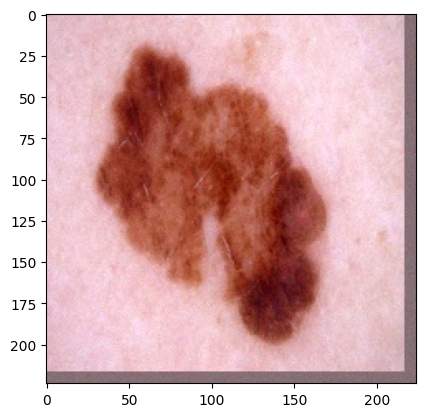

In [3]:
plt.imshow(np.load('/kaggle/input/multimodal-skin-classification/train_images.npy')[2])

In [4]:
np.load('/kaggle/input/multimodal-skin-classification/train_tabular.npy')

array([[22. ,  0. ,  0. ],
       [56. ,  0. ,  1. ],
       [36.4,  1. ,  2. ],
       ...,
       [57.2,  1. ,  1. ],
       [52.5,  1. ,  2. ],
       [61.9,  0. ,  5. ]], dtype=float32)

In [5]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch

# found the model here
# https://huggingface.co/actavkid/vit-large-patch32-384-finetuned-skin-lesion-classification

# Load model and processor
model_id = "actavkid/vit-large-patch32-384-finetuned-skin-lesion-classification"
processor = ViTImageProcessor.from_pretrained(model_id)
model = ViTForImageClassification.from_pretrained(model_id)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
model.eval()

2026-02-12 09:59:45.736460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770890385.919049      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770890385.969495      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770890386.400209      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770890386.400249      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770890386.400252      24 computation_placer.cc:177] computation placer alr

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, bias=True)
           

In [6]:
def organize_data(split, batch_size=64):
    df = pd.DataFrame()
    df['id'] = np.load(f'/kaggle/input/multimodal-skin-classification/{split}_ids.npy', allow_pickle=True)
    df[['age', 'sex', 'site']] = np.load(f'/kaggle/input/multimodal-skin-classification/{split}_tabular.npy')
    if split=='train':
        df['label'] = np.load(f'/kaggle/input/multimodal-skin-classification/{split}_labels.npy')
    df['site'] = df['site'].map({0.0: 'head/neck', 1.0: 'palms/soles', 2.0: 'lower extremity', 3.0: 'torso', 4.0: 'upper extremity', 5.0: 'oral/genital'})
    df['sex'] = df['sex'].map({0.0: 'male', 1.0: 'female'})
    
    images = np.load(f'/kaggle/input/multimodal-skin-classification/{split}_images.npy')

    probabilities = []
    
    for i in tqdm(range(0, len(images), batch_size), desc='Processing Images'):
        inputs = processor(images=images[i:i+batch_size], return_tensors="pt").to(device)
        # Make prediction
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get prediction results
        logits = outputs.logits
        # prob = torch.nn.functional.softmax(logits, dim=1).cpu()
        prob = logits.cpu()
        probabilities.append(prob)

    probabilities = torch.cat(probabilities, dim=0)
        
    df[[f'prob_{i}' for i in range(12)]] = np.array(probabilities)
    return df, images

train, train_images = organize_data('train')
test, test_images = organize_data('test')

train.shape, test.shape

Processing Images:   0%|          | 0/63 [00:00<?, ?it/s]

Processing Images:   0%|          | 0/16 [00:00<?, ?it/s]

((4000, 17), (1000, 16))

In [7]:
train.head()

,id,age,sex,site,label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11
0,img_04cf203df2b3,22.000000,male,head/neck,4,-3.005179,-3.361559,-1.851346,-0.845670,3.418859,-2.435997,9.513906,-0.582319,-0.393149,-1.858633,-2.159005,-1.531809
1,img_17ce64a6831f,56.000000,male,palms/soles,4,-3.132623,-2.957669,-1.189242,-1.510502,1.481956,0.926315,6.795914,0.621813,-0.869078,-2.544925,-1.592457,0.121644
2,img_a23e91c56f31,36.400002,female,lower extremity,3,-1.535122,-2.800738,-2.529636,-2.270424,11.261221,-1.708628,0.274410,-0.285168,-2.248514,-0.015486,-1.071753,-1.856936
3,img_9acdbf4b648d,35.200001,female,torso,4,-2.396670,-1.463658,-2.401545,-2.633450,0.675163,-1.274183,12.239856,-0.933120,-2.136967,-2.552685,-1.070334,-1.762298
4,img_551ab73608f8,70.500000,male,palms/soles,3,-4.602283,1.070063,-3.075810,-1.855011,8.076884,-1.532134,3.807613,-2.583850,-1.078883,-1.223045,-2.413153,-2.391390


In [8]:
train['label'].map(idx2class).value_counts(normalize=True).sort_index()

label
akiec    0.03425
bcc      0.05850
bkl      0.11075
df       0.01075
mel      0.10975
nv       0.66150
vasc     0.01450
Name: proportion, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split

train, valid, train_images, valid_images = train_test_split(train, train_images, stratify=train['label'], test_size=0.1, random_state=42)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

train.shape, valid.shape, train_images.shape, valid_images.shape

((3600, 17), (400, 17), (3600, 224, 224, 3), (400, 224, 224, 3))

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

class LesionDataset(Dataset):
    def __init__(self, images, df, transform=None):
        self.images = images
        self.df = df.copy()
        self.df['sex'] = self.df['sex'].map({'male': 0, 'female': 1})
        self.df['site'] = self.df['site'].map({'head/neck': 0, 'palms/soles': 1, 'lower extremity': 2, 'torso': 3, 'upper extremity': 4, 'oral/genital': 5})
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform is not None:
            img = self.transform(img)

        row = self.df.iloc[idx]
        age, sex, site = row['age'], row['sex'], row['site']
        probs = torch.tensor(row[[f'prob_{i}' for i in range(12)]].astype(float).values, dtype=torch.float32)
        
        if 'label' not in self.df.columns:
            return img, age, sex, site, probs
            
        label = torch.tensor(row['label'])
        return img, age, sex, site, probs, label

transform_train = v2.Compose([
    v2.RandomRotation(20),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    v2.ToTensor()
])

transform_infer = v2.Compose([
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    v2.ToTensor()
])

train_ds = LesionDataset(train_images, train, transform_train)
valid_ds = LesionDataset(valid_images, valid, transform_infer)
test_ds = LesionDataset(test_images, test, transform_infer)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
len(train_loader), len(valid_loader), len(test_loader)

(113, 13, 32)

In [12]:
from sklearn.metrics import f1_score

def fit(model, criterion, optimizer, train_loader, valid_loader, epochs=10, log_rate=1):

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_f1': [],
        'valid_f1': []
    }
    
    for epoch in tqdm(range(epochs), desc='Epoch'):
        model.train()
        i, rloss = 0, 0
        all_y, all_pred = [], []
        for X, age, sex, site, probs, y in (pbar := tqdm(train_loader, desc='Train Loader', leave=False)):
            X, age, sex, site, probs, y = X.to(device), age.to(device), sex.to(device), site.to(device), probs.to(device), y.to(device)
            output = model(X, age, sex, site, probs)
            loss = criterion(output, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            rloss += loss.item()
            i += 1
            all_y.extend(y.flatten().tolist())
            all_pred.extend(torch.argmax(output, dim=1).flatten().detach().cpu().tolist())
            f1 = f1_score(all_y, all_pred, average='weighted')
            pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'f1': f'{f1:.5f}'})
    
        history['train_loss'].append(rloss/i)
        history['train_f1'].append(f1)
        if (epoch+1) % log_rate == 0:
            print(f'Epoch: {epoch+1}/{epochs}')
            print(f'Train Loss: {rloss/i:.5f} | Train F1: {f1:.5f}')
    
        model.eval()
        i, rloss = 0, 0
        all_y, all_pred = [], []
        for X, age, sex, site, probs, y in (pbar := tqdm(valid_loader, desc='Valid Loader', leave=False)):
            X, age, sex, site, probs, y = X.to(device), age.to(device), sex.to(device), site.to(device), probs.to(device), y.to(device)
            with torch.no_grad():
                output = model(X, age, sex, site, probs)
                loss = criterion(output, y)
    
            rloss += loss.item()
            i += 1
            all_y.extend(y.flatten().tolist())
            all_pred.extend(torch.argmax(output, dim=1).flatten().cpu().tolist())
            f1 = f1_score(all_y, all_pred, average='weighted')
            pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'f1': f'{f1:.5f}'})
    
        history['valid_loss'].append(rloss/i)
        history['valid_f1'].append(f1)    
        if (epoch+1) % log_rate == 0:
            print(f'Valid Loss: {rloss/i:.5f} | Valid F1: {f1:.5f}')

    return history

In [13]:
from torchvision import models

class MultimodalModel(nn.Module):
    def __init__(self, sex_emb_size=2, site_emb_size=4, probs_size=12):
        super().__init__()
        self.image_model = models.resnet18(models.ResNet18_Weights.DEFAULT)
        self.image_model.fc = nn.Linear(512, 512)

        self.sex_embs = nn.Embedding(2, sex_emb_size)
        self.site_embs = nn.Embedding(6, site_emb_size)
        self.shared = nn.Sequential(
            nn.Linear(sex_emb_size+site_emb_size+probs_size+512+1, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 7)
        )

    def forward(self, X, age, sex, site, probs):
        X = self.image_model(X)
        whole = torch.cat((X, age.unsqueeze(-1), self.sex_embs(sex), self.site_embs(site), probs), dim=1)
        return self.shared(whole)

In [14]:
from torchvision import models
from itertools import chain

model = MultimodalModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

model = model.to(device)

unique, counts = np.unique(train['label'], return_counts=True)
class_weights = torch.tensor([
    len(train['label']) / counts[i] for i in range(7)
], dtype=torch.float32).to(device)
class_weights = class_weights / class_weights.sum() * 7

criterion = nn.CrossEntropyLoss(class_weights)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [15]:
history = fit(model, criterion, optimizer, train_loader, valid_loader)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 1/10
Train Loss: 1.86558 | Train F1: 0.40926


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.71193 | Valid F1: 0.64975


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 2/10
Train Loss: 1.55486 | Train F1: 0.69817


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.28502 | Valid F1: 0.73042


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 3/10
Train Loss: 1.10072 | Train F1: 0.74669


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 0.93351 | Valid F1: 0.76574


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 4/10
Train Loss: 0.71047 | Train F1: 0.79617


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 0.85583 | Valid F1: 0.77254


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 5/10
Train Loss: 0.45496 | Train F1: 0.83713


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 0.84633 | Valid F1: 0.80003


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 6/10
Train Loss: 0.31006 | Train F1: 0.86379


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 0.95028 | Valid F1: 0.79600


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 7/10
Train Loss: 0.20207 | Train F1: 0.89279


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.01028 | Valid F1: 0.81027


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 8/10
Train Loss: 0.13186 | Train F1: 0.92592


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.02364 | Valid F1: 0.77914


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 9/10
Train Loss: 0.08728 | Train F1: 0.94871


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.12277 | Valid F1: 0.79290


Train Loader:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 10/10
Train Loss: 0.05296 | Train F1: 0.97009


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.17296 | Valid F1: 0.80737


In [16]:
model.eval()
all_pred = []
for X, age, sex, site, probs in (pbar := tqdm(test_loader, desc='Test Loader', leave=False)):
    X, age, sex, site, probs = X.to(device), age.to(device), sex.to(device), site.to(device), probs.to(device)
    with torch.no_grad():
        output = model(X, age, sex, site, probs)
        
    all_pred.extend(torch.argmax(output, dim=1).flatten().cpu().tolist())

Test Loader:   0%|          | 0/32 [00:00<?, ?it/s]

In [17]:
subm = pd.read_csv("/kaggle/input/multimodal-skin-classification/sample_submission.csv")

subm['diagnosis'] = list(map(idx2class.get, all_pred))

subm.to_csv("submission.csv", index=False)

subm.head()

,image_id,diagnosis
0,img_7ba9dbbf6a91,mel
1,img_8df2caa3e3e6,nv
2,img_32f3f5fa9b89,nv
3,img_9bf1ef6b12b6,bcc
4,img_bd1a36b5aac1,nv


In [18]:
subm['diagnosis'].value_counts(normalize=True).sort_index()

diagnosis
akiec    0.030
bcc      0.055
bkl      0.108
df       0.004
mel      0.111
nv       0.674
vasc     0.018
Name: proportion, dtype: float64